In [42]:
# TODO Rewrite this code from scratch with minimal support from solution.

import pandas as pd
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [44]:
from pathlib import Path
csvpath = Path('../Resources/gold_price.csv')
df = pd.read_csv(csvpath, parse_dates=True, index_col='Date')
df.head()

,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
Date,,,,,,
2001-01-02,272.80,271.10,183.026,181.617,288.677,287.334
2001-01-03,269.00,267.15,178.916,177.390,281.823,281.655
2001-01-04,268.75,267.10,178.869,178.352,282.538,282.049
2001-01-05,268.00,267.40,178.488,178.148,280.775,280.882
2001-01-08,268.60,268.30,178.769,178.664,282.410,282.481


In [45]:
df['Return'] = df['USD (PM)'].pct_change() * 100
df['Lagged_Return'] = df.Return.shift()
df = df.dropna()
df.head()

,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM),Return,Lagged_Return
Date,,,,,,,,
2001-01-04,268.75,267.1,178.869,178.352,282.538,282.049,-0.018716,-1.457027
2001-01-05,268.00,267.4,178.488,178.148,280.775,280.882,0.112317,-0.018716
2001-01-08,268.60,268.3,178.769,178.664,282.410,282.481,0.336574,0.112317
2001-01-09,267.75,267.0,179.855,179.195,284.507,283.590,-0.484532,0.336574
2001-01-10,266.70,266.3,178.777,178.665,283.573,283.298,-0.262172,-0.484532


<AxesSubplot:xlabel='Date'>

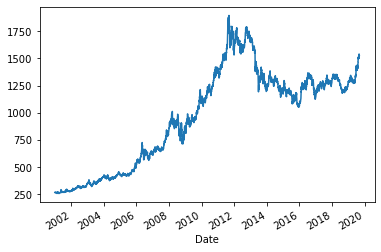

In [46]:
df['USD (PM)'].plot()

# Train Test Split Predictions

Training Period: 2001-2018
Testing Period: 2019

In [47]:
df.head(1)

,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM),Return,Lagged_Return
Date,,,,,,,,
2001-01-04,268.75,267.1,178.869,178.352,282.538,282.049,-0.018716,-1.457027


In [48]:
# Create a train/test split for the data using 2001-2018 for training and 2019 for testing
train = df["2001":"2018"]
test  = df["2019"]

In [49]:
# Create train and test sets for dependent and independent variables
x_train = train.Lagged_Return.to_frame()
x_test  = test.Lagged_Return.to_frame()
y_train = train.Return
y_test  = test.Return


In [50]:
# Create and fit model to the data, make predictions
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [51]:
in_sample_results       = model.predict(x_train)
out_of_sample_results   = model.predict(x_test)

# Construct a DataFrame using just the "y" training data:
df_train    = pd.DataFrame({"y_train": y_train, "y_predict_insample": in_sample_results})
df_test     = pd.DataFrame({"y_test": y_test, "y_predict_outsample": out_of_sample_results})

# Add a column of "out-of-sample" predictions to that DataFrame:  


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

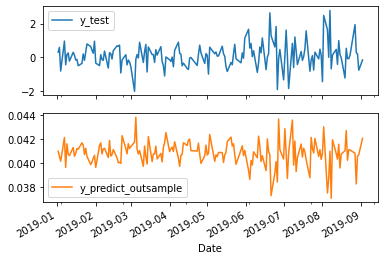

In [52]:
# Plot the out-of-sample results for 2019
df_test.plot(subplots=True)

In [53]:
# Calculate out-of-sample mean_squared_error (for comparison to out-of-sample)
mse = mean_squared_error(y_test, out_of_sample_results)

# Calculate out-of-sample root mean_squared_error (for comparison to out-of-sample)
out_of_sample_rmse = np.sqrt(mse)

print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

Out-of-sample Root Mean Squared Error (RMSE): 0.7386178760826811


---

# Rolling Out-of-Sample Predictions

In [54]:
# Split the index into weekly periods
weeks = df.index.to_period("w").unique()
print(weeks[0])

2001-01-01/2001-01-07


In [55]:
# Declare the training window of 12 weeks
# Define the time frame of rolling windows
training_window = 12
timeframe = len(weeks) - training_window - 1

x_train = weeks[0:training_window]
x_train

PeriodIndex(['2001-01-01/2001-01-07', '2001-01-08/2001-01-14',
             '2001-01-15/2001-01-21', '2001-01-22/2001-01-28',
             '2001-01-29/2001-02-04', '2001-02-05/2001-02-11',
             '2001-02-12/2001-02-18', '2001-02-19/2001-02-25',
             '2001-02-26/2001-03-04', '2001-03-05/2001-03-11',
             '2001-03-12/2001-03-18', '2001-03-19/2001-03-25'],
            dtype='period[W-SUN]', name='Date', freq='W-SUN')

In [56]:
# Construct empty placeholder DataFrames.
# (During each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
all_actuals = pd.DataFrame(columns=["Actual Returns"])

In [57]:
# During rolling iteration, split into train and test sets.
# Use linear regression to make out-of-sample predictions.
# Append the results to external DataFrames.

for i in range(0, training_window):

    # Beginning of training window
    start_of_training_period = weeks[i].start_time.strftime(format="%Y-%m-%d")
    
    # End of training window
    end_of_training_period = weeks[training_window + i].end_time.strftime(format="%Y-%m-%d")

    # Window of test-window data
    test_week = weeks[training_window+i+1]
    
    # String of testing window
    start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
    end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
    
    train = df[start_of_training_period:end_of_training_period]
    test = df[start_of_test_week:end_of_test_week]
    
    # Create new DataFrames:
    X_train = train["Lagged_Return"].to_frame()
    y_train = train["Return"]
    X_test = test["Lagged_Return"].to_frame()
    y_test = test["Return"]

    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    # Create a temporary DataFrame to hold predictions
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
    # Create a temporary DataFrame of the actual "y"s in the test DataFrame, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns"]  
    # Append these two DataFrames (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)

In [58]:
Results = pd.concat([all_actuals, all_predictions], axis=1)
Results.head()

,Actual Returns,Out-of-Sample Predictions
2001-04-02,-0.679084,-0.230810
2001-04-03,0.449307,-0.178308
2001-04-04,0.914041,0.047224
2001-04-05,-0.520331,0.140111
2001-04-06,0.271213,-0.146578


In [59]:
# 2019 Data
results_2019 = Results.loc['2019':]
results_2019

,Actual Returns,Out-of-Sample Predictions


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

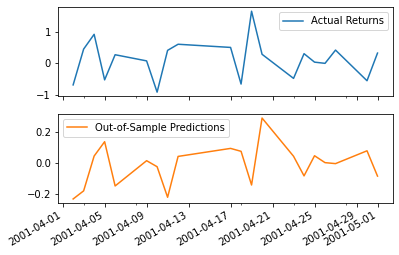

In [62]:
# Plot the 2019 results
Results[:20].plot(subplots=True)

In [61]:
# Out-of-sample metrics
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the DataFrame above)
# YOUR CODE HERE!

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
# YOUR CODE HERE!
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

NameError: name 'rmse' is not defined